# Define Spatial Extent of Project

This notebook retrieves Metropolitan Council's 2010 boundaries of the Twin Cities area and extracts the Minneapolis's boundary and buffers 26 kilometers (large emissions were [shown to travel this distance](https://plumepgh.org/model_data.html) if the wind blows right). Both Minneapolis and the Extent are saved as a geojson.

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/us-mn-state-metc-bdry-census2010counties-ctus

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/bdry_census2010counties_ctus/metadata/metadata.html


In [1]:
### Import Packages

# File manipulation

import os # For working with Operating System
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Database 

import psycopg2

# Analysis

import arcpy
import pandas as pd

# Get CWD

cwd = os.getcwd()

# Create GeoDataBase

arcpy.management.CreateFileGDB(cwd, 'extent_gdb')

# Make it workspace

arcpy.env.workspace = os.path.join(cwd, 'extent_gdb.gdb')

In [2]:
### Definitions

def extract_zip_from_url(url=None):
    '''Extract a zipfile from the internet
    then unpack it in to it's own folder 
    within the working directory.
    Takes a single url (string).'''
    
    if type(url) == str: # Single url
        # Create folder name for file
        folder_name = url.split('/')[-1][:-4]
        # Make folder for files
        path = os.path.join(os.getcwd(), folder_name)
        if folder_name not in os.listdir():
            os.mkdir(path)
        # Unload zip into the new folder
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall(path=path) # Extract files
        zip_folder.close() # Close zip object
    else:
        print('Error Extracting: Invalid Input')

In [3]:
# Download Data

## Twin Cities Metro Boundaries - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)

url = "https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/bdry_census2020counties_ctus/shp_bdry_census2020counties_ctus.zip"

extract_zip_from_url(url)

<AxesSubplot:>

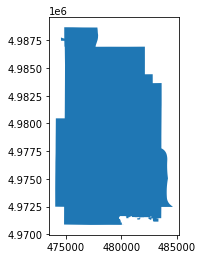

In [4]:
# Read & Select

# Get path

folder = url.split('/')[-1][:-4] # Get folder name (last part of address minus .zip)
filename = 'Census2020CTUs.shp'
path = os.path.join(folder, filename)

arcpy.MakeFeatureLayer_management(path,"TCMA_lyr")

mpls_boundary = arcpy.management.SelectLayerByAttribute("TCMA_lyr", "SUBSET_SELECTION", "[CTU_NAME] = Minneapolis")

# Write the selected features to a new featureclass
# arcpy.CopyFeatures_management("TCMA_lyr", "mpls_boundary")

# Save as a geojson

arcpy.conversion.FeaturesToJSON(mpls_boundary, 'mpls_boundary.geojson', geoJSON='GEOJSON')

# Add column for WKT

arcpy.management.AddField(mpls_boundary, 'WKT', 'TEXT')
arcpy.management.CalculateField(mpls_boundary, 'WKT',
                                "!SHAPE.WKT!",
                                "PYTHON3")

# Convert to pandas dataframe

cols = ['CTU_ID', 'CTU_NAME', 'CTU_CODE', 'WKT']

df = pd.DataFrame(arcpy.da.FeatureClassToNumPyArray(mpls_boundary, 
                                                      cols,
                                                      skip_nulls=False, null_value=-99999))

In [ ]:
# Upload to Database

# Connect to PostGIS Database

pg_connection_dict = {
    'dbname': 'MplsCommunityAir',
    'user': 'postgres',
    'password': 'postgres',
    'port': '5432',
    'host': '35.232.191.92'
}

conn = psycopg2.connect(**pg_connection_dict)

# Create Cursor for commands

cur = conn.cursor()

# Insert into table

for i, row in df.iterrows():
    
    cur.execute(
        'INSERT INTO PurpleAir.Minneapolis_Boundary(CTU_ID, CTU_NAME, CTU_CODE, geometry)'
        'VALUES (%(ctu_id)s, %(ctu_name)s, %(ctu_code)s, ST_Transform(ST_SetSRID(ST_GeomFromText(%(geom)s), 26915),4326)::geometry);',
        {'ctu_id': row.CTU_ID,
         'ctu_name' : row.CTU_NAME,
         'ctu_code': row.CTU_CODE,
         'geom': row.WKT})

    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()